The basics of the Non-doinated Sorting Genetic Algorithm are http://ieeexplore.ieee.org/document/996017/

In [36]:
%matplotlib inline
#Importing required modules
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
import scipy.stats as stats
import warnings
from matplotlib.colors import LogNorm
from prettytable import PrettyTable

# 0. Function definition


## 0.0 $\textit{Individual}$ class definition for the sorting function 

In [523]:
# This class will be used in the fastNonDominatedSorting to make a neat code
class Individual(object):
    p = []
    n = 0
    # Each individual will have p and n
    def __init__(self, p, n):
        self.p = p
        self.n = n

## 0.1 $\prec$ operator
The dominance operation is usually defined mathematicaly as:
\begin{matrix}
    f_i(x^1) \leq f_i(x^2) && \text{for all } i \text{ in } i \in {1, 2, ..., k}\\
    f_i(x^1) < f_i(x^2) && \text{for at least one } i \text{ in } i \in {1, 2, ..., k}
\end{matrix}

In [522]:
def prec_operator(P,Q):
    """Implementation of the dominance operator to sort a set of points.
    
    INPUTS:
    P:    first point (value in the function domain) with numpy.ndarray type
    Q:    second point (value in the function domain) with numpy.ndarray type
     
    OUTPUT:
    bool: True if P < Q and False if Q < P
    
    
    The dominance (precedant) operator returns True or False depending on the values 
    that the different functions have for each point. This follows the formal definition
    of the precedant operator: in order have a point dominating another, the values of 
    the functions should be smaller or equal for all objectives, having AT LEAST one for 
    which the values is strictly smaller than the dominated points 
    """
        
    # Number of variables
    var = P.shape[0]
    
    # Dimensions between p and q must match
    if var != Q.shape[0]:
        raise ValueError("P and Q dimensions don't match")
    
    # If all elements in P are smaller than those in Q, then P is dominating
    if np.sum(P < Q) == var:
        return True
    # Formal dominance-operator definition
    elif np.sum(np.logical_or(P < Q, P == Q)) == var and np.sum(P < Q) >= 1: 
        return True
    else:
        return False

## 0.2 $\texttt{fastNonDominatedSort}$ function 
Extracted from http://ieeexplore.ieee.org/document/996017/

In [532]:
def fastNonDominatedSort(P):
    """fast-non-dominated-sorting algorithm decribed in the NSGA-II paper
    
    INPUT:
    P:  point evaluations in the function space as a numpy.ndarray
    
    OUTPUT:
    PF: Pareto Front points in a list (number of PF) of numpy.ndarray (points)
    F:  index points in a list (number of PF) of numpy.ndarray (index)
    
    
    The function analyzes the value of the functions in the array P and sort the points 
    in Pareto Fronts, having that PF[0] contains the non dominated values in the set P, 
    PF[1] contains the values of the first dominated set, PF[1] the values of the second, 
    and so on. List F[] has the same idea of PF[] but containing the index of the points 
    instead of the true value of the point.
    """
    
    # Number of variables of the problem
    var = P.shape[1]
    # Possible solutions
    ps = P.shape[0] 
    ind = []
    # Pareto front list
    F = []
    # Let's create an empty array for the 1st Pareto front
    F1 = np.empty((0,1), float) # Just the index of the point will be stored

    for i in range(ps):
        # Dominated solutions for each p and its domination count n_p for the solution 
        S_p = np.empty((0,1), float) 
        n_p = 0
        for j in range(ps):
            # If p dominates q in all variables it will be smaller in all variables
            if prec_operator(P[i],P[j]): 
                S_p = np.append(S_p, j) # Add q to the set of solutions dominated by p
            elif prec_operator(P[j],P[i]):
                n_p += 1 # Increment the domination counter of p
        if n_p == 0: # p belongs to the first front
    #         p_rank = 1 
            F1 = np.append(F1, i) # Let's include the rank after the two main variables
        ind.append(Individual(S_p, n_p))
    # Store the first frontier in the frontiers list
    F.append(F1.astype(int))

    front = 0

    while len(F[front]) != 0:
        Q = np.empty((0,1), float) # Used to store the members of the next front
        for i in range(F[front].size): 
            for j in range(ind[int(F[front][i])].p.size):
                # Reduce the domination counter by 1
                ind[int(ind[int(F[front][i])].p[j])].n -= 1 
                # q belongs to the next front if its n == 0
                if ind[int(ind[int(F[front][i])].p[j])].n == 0: 
#                     q_rank = front + 2 
                    Q = np.append(Q, int(ind[int(F[front][i])].p[j]))
        front += 1
        F.append(Q.astype(int))

    # Let's create the values of the points instead index
    PF = []
    for i in range(front):
        PF.append(P[F[i].astype(int).tolist()])
        
    return PF, F

## 0.3 $\texttt{crowdingDistanceAssignment}$ function 
Extracted from http://ieeexplore.ieee.org/document/996017/

In [521]:
def crowdingDistanceAssignment(PF):
    """Assignment of a crowding distance value for a specific Pareto Front.
    
    INPUT:
    PF: specific Pareto Front values in the function space as numpy.ndarray
    
    OUTPUT:
    I:  crowding distance between points as a numpy.ndarray
    
    
    The implementation is based on the procedure proposed in the NSGA-II paper:
        - Assign a value in the extrema of infinity
        - Computes the crowding distance between the other points
        - Store the results following the same order as the points in PF
    """
    l = PF.shape[0] # Number of solutions in PF
    m = PF.shape[1] # Number of objective functions
    I = np.zeros((l,m)) # Preallocate distance
    for i in range(m):
        temp = PF[np.argsort(PF[:,i])] # Sort by using objective value m
        # Boundary points are selected as infinite so they will always be choosen
        I[0,i] = float('inf') 
        I[-1,i] = float('inf')
         # For the points that are not in the boundaries
        for j in range(0,l-2):
            I[j+1,i] = (temp[j+2,i] - temp[j,i])/(temp.max(axis=0)[i]-temp.min(axis=0)[i])    
    return I

## 0.4 $\prec_n$ sorting
Although $\prec_n$ is described in http://ieeexplore.ieee.org/document/996017/ as:
$$
i \prec_n j \text{ if any of these is true }
\begin{Bmatrix}
    i_{rank} < j_{rank} \\
    i_{rank} == j_{rank} \ \ \mathbf{ and } \ \ i_{dist} > j_{dist}
\end{Bmatrix}
$$

In order to make a complete comparison with all the objective functions, the next function:
* Receives two vectors containing the rank and the crowding distance in each one of the objectives
* The points are sorted by comparing the mean of both objective functions in order to untie any possible mismatch between them

In [513]:
def prec_n_operator(rank, crowd):
    """Implementation of the precedent_n operator to sort a set of points.
    
    INPUTS:
    rank:  ranking of the individuals as a numpy.ndarray 
    crowd: crowding distances stored in a numpy.ndarray
    
    OUTPUT:
    fObj:  returns a numpy.ndarray with the index of the sorted points (as integers)
    
    
    The implementation follows a close procedure to the one described in NSGA-II paper but 
    untie possible objective mismatches by using the mean to get the point located in the
    less populated area (bigger densities and bigger max(rank)-rank first)
    """
    
    # Let's invert the ranks to sort descending in all variables. Thus, the highest
    # the value of the new rank, the better Pareto front the point is located in.
    rank = max(rank) - rank

    # Descending sorted matrix taking into account rank and mean of crowding distances
    obj = np.flipud(np.lexsort(((crowd[:,0]+crowd[:,1])/2,rank)))
    # Before returning the index list, check if there is no repeated number
    if any(np.unique(obj, return_counts=True)[1] != 1):
        # If there it is, return a warning
        warnings.warn("Repeated numbers in the prec_n_operator output")
    # Return the solution
    return obj.astype(int)

## 0.5 $\texttt{preSelection}$ function
Extracted from http://ieeexplore.ieee.org/document/996017/

In [530]:
def preSelection(P, Q, funEvalP, funEvalQ):
    """Selection based on the mixing of parents and offsprings 
    
    INPUTS:
    P:        parents (in parameter space) as a numpy.ndarray
    Q:        offspring [p] (in parameter space) as a numpy.ndarray
    funEvalP: parents (in function space) as a numpy.ndarray
    funEvalQ: offsprings (in function space) as a numpy.ndarray
    
    OUTPUT:
    newP:     new population ready for selection, crossover...


    This function mix the population of parents (generation [p-1]) and offsprings 
    (generation [p]). Then it is sorted following the non-dominated sorting, taking 
    the whole fronts when they fill completely the new population size. Once the next
    front doesn't fit into the new population vector, it is sorted by crowding distance
    picking the ones that have higher values of crowding distances. 
    """
    
    N = len(P)
    # Combine parent and offspring population
    R = np.concatenate((P,Q))
    funEvalR = np.concatenate((funEvalP,funEvalQ))
    
    # Let's sort all the nondominated fronts of R
    PF, F = fastNonDominatedSort(funEvalR)
    
    # Store the Pareto Front number of each one of the P points
    PFnumber = np.zeros(len(np.concatenate(PF))) 
    count = 0
    for pfn in range(len(F)):
        for pfe in range(len(F[pfn])):
            PFnumber[F[pfn][pfe].astype(int)] = pfn
            count += 1

    # New generation should have the same number of individuals as the previous one
    newP = np.zeros((N, 5)) # coord1 - coord2 - rank - crowd1 -crowd2

    i = 0
    nPcount = 0
    
    # Until the parent population is filled
    while np.sum(newP.any(axis=1)) + len(F[i]) <= N:
        # Calculate the crowding-distance for F[i]
        crowdDA = crowdingDistanceAssignment(funEvalR[F[i]])
        # Include the i-th nondominated front in the parent population
        for j in range(len(F[i])):
            newP[nPcount,:] = np.hstack((R[F[i][j],:], PFnumber[F[i][j]], crowdDA[j,:]))
            nPcount += 1
        # Check the next front for inclusion
        i += 1

    # Compute the crowding distance for the next F[i] 
    crowdDA = crowdingDistanceAssignment(funEvalR[F[i]])
    # Sort in descensing order using the prec_n operator
    sortedFl = prec_n_operator(PFnumber[F[i]],crowdingDistanceAssignment(funEvalR[F[i]]))

    # Choose the first (N-len(F[i])) elements of F[i]
    stillEmpty = N - np.sum(newP.any(axis=1))
    for j in sortedFl[0:stillEmpty]:
        newP[nPcount,:] = np.hstack((R[F[i][j],:], PFnumber[F[i][j]], crowdDA[j,:]))
        nPcount += 1

    # Return the new population ready to selection
    return newP

## 0.6 $\texttt{binaryTournament}$ function
The algorithm for the binary tournament selection has been coded following: http://www.tik.ee.ethz.ch/file/6c0e384dceb283cd4301339a895b72b8/TIK-Report11.pdf

In [515]:
def binaryTournament(rank, crowd):
    """Binary tournament selection process based on the precedent_n operator
    
    INPUTS:
    rank:  rank (Pareto front number) in which points are located
    crowd: crowding distance of the points that will be confronted
    
    OUTPUT:
    index: index of the winning individual
    
    
    The basic operation that this function performs is the selection of two
    random individuals from a list, comparison of its rank and crowding 
    distance and select the winner based on the precedent_n operator
    """
    
    # Get the size of the population
    N = rank.shape[0]
    
    # Dimensions between rank and crowd must match
    if N != crowd.shape[0]:
        raise ValueError("Rank and crowd dimensions don't match")
    
    # Create an array with the N possible index positions
    indx = np.linspace(0,N-1,N).astype(int)
    
    # Get two random positions for each one of the contestants
    cntA = np.random.choice(indx)
    cntB = np.random.choice(indx)
    
    # Avoid mutual participation in the tournament
    while cntA == cntB:
        cntA = np.random.choice(indx)
        cntB = np.random.choice(indx)   
            
    # List contestants, its rank and its crowding distance
    cntList = np.array([cntA,cntB])
    cntRank = np.array([rank[cntA],rank[cntB]])
    cntCrowd = np.array([crowd[cntA],crowd[cntB]])
    
    # Apply the dominance_n operator to get the winner
    winner = prec_n_operator(cntRank, cntCrowd)

    # The winner is the element 0 from the prec_n operation
    return cntList[winner == 0][0]

## 0.7 Crossover

In [503]:
def crossover(ind1, ind2, d, line):
    """Crossover of two individuals with intermediate or linear recombination
    
    INPUTS:
    ind1: first individual as numpy.ndarray
    ind2: second individual as numpy.ndarray
    d:    spacing area of possible offspring location
    line: True for linear recombination, False for intermediate recombination
    
    OUTPUTS:
    off:  new individual as numpy.ndarray
    
    
    The crossover is based on:
                         x_o = x_1 * a_i + x_2 * (1 - a_i)
    to get new individuals. The difference between linear and intermediate recombination
    is that for intermediate recombination the value of a_i is computed for each variable 
    while for linear recombination a_i will be the same for all variables. 
    
    a_i is chosen randomly from the interval [-d,1+d] where d is the input value. The most 
    common value of d is 0.25 because it ensures diversity (at least statistically)."""
    
    # Preallocation of space for the offspring as the parents
    off = np.zeros_like(ind1)
     
    if line:
        # Generate one a_i for all possible variables of the individual
        a_i = random.uniform(-d, 1+d)
        for i in range(ind1.shape[0]):
            # Mutate each variable with the same a_i
            off[i] = ind1[i]*a_i + ind2[i]*(1 - a_i)
    else:
        for i in range(ind1.shape[0]):
            # For each variable, compute a random a_i and mutate
            a_i = random.uniform(-d, 1+d)
            off[i] = ind1[i]*a_i + ind2[i]*(1 - a_i)
    
    return off

## 0.8 Mutation

In [516]:
def mutation(ind, r, domain, k, normalDist):
    """Mutates the individual with uniform or normal distribution
    
    INPUTS:
    ind:        individual as numpy.ndarray
    r:          range of mutation [0-1] multiplied by the domain
    domain:     search domain for each variables of ind as numpy.ndarray
    k:          mutation precision for a_i = 2^(u_i * k)
    normalDist: True for normal distribution, False for uniform random
    
    OUTPUTS:
    mInd:       mutated individual as numpy.ndarray
    
    
    The mutation is defined by:
            x_m = x_i + s_i * r * domain * 2^(u_i * k)
    where the values depend on the different input parameters. Common ranges
    for those inputs are:
        - r = [1e-1,1e-6]
        - k = [4-20]
    """
    
    # Preallocation of space for the mutated individuals
    mInd = np.zeros_like(ind)
    
    # Random sign vector with positive and negative signs 
    s_i = [1,-1]
    
    # Perform the mutation for each individual in the list
    for i in range(ind.shape[0]):
        if normalDist:
            # A truncated normal distribution as the normal distribution in [-1, 1] 
            mInd[i] = ind[i] + r*domain[i]*stats.truncnorm(-2, 2, loc=0, scale=0.5).rvs(1) 
        else:
            # Otherwise an uniform random distribution will be used
            mInd[i] = ind[i] + random.choice(s_i)*r*domain[i]*2**(-np.random.rand()*k)

    return mInd

# 1. Examples to test the different functions

## 1.1 Simple Pareto sorting test

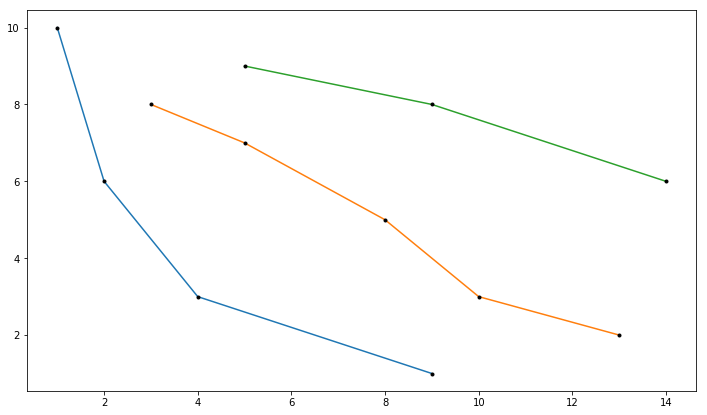

In [23]:
P = np.array([[1,10],[2,6],[3,8],[4,3],[5,7],[5,9],[8,5],[9,1],[10,3],[9,8],[13,2],[14,6]])

PF, F = fastNonDominatedSort(P)
I = crowdingDistanceAssignment(PF[0])

fig, ax = plt.subplots(1, figsize=(12,7))
for i in range(len(PF)):
    ax.plot(PF[i][:,0],PF[i][:,1])
    ax.plot(PF[i][:,0],PF[i][:,1],'k.')

## 1.2 Multiobjective testing of the $\texttt{fastNonDominatedSort}$ and $\texttt{crowdingDistanceAssignment}$ functions

In [421]:
########################### FUNCTION DEFINITION 
funNo = 2

def fun(x,y,no):
    #Attribute of the function to know the real number of callings to the function
    fun.counter += x.shape[0]/funNo
    if no == 0:
        return 4*x**2+4*y**2
    if no == 1:
        return (x-5)**2+(y-5)**2
    
########################### CONSTRAINTS DEFINITION 
def const(x,y,no):
    #Let's use Python notation so the first equation will be no=0...
    if no == 0:
        return (x-5)**2+y**2
    if no == 1:
        return (x-8)**2+(y+3)**2
    
constVal = [25, 7.7]
compMode = ['leq', 'geq']

########################### DOMAIN DEFINITION
x_low = 0
x_high = 5
y_low = 0
y_high = 3

In [422]:
#Number of used points
noPoints = 500

#Get a random set of points
x = x_low+np.random.rand(noPoints)*(x_high-x_low)
y = y_low+np.random.rand(noPoints)*(y_high-y_low)

#Make a copy of the points X-Y to extract the valid ones
valid_x = np.copy(x)
valid_y = np.copy(y)

#Let's get the points that are valid under the constraints
for i in range(len(constVal)):
    if compMode[i] == 'leq':
        boolMat = np.logical_or(const(valid_x, valid_y, i) < constVal[i], const(valid_x, valid_y, i) == constVal[i])
    elif compMode[i] == 'less':
        boolMat = const(valid_x, valid_y, i) < constVal[i]
    elif compMode[i] == 'geq':
        boolMat = np.logical_or(const(valid_x, valid_y, i) > constVal[i], const(valid_x, valid_y, i) == constVal[i])
    elif compMode[i] == 'greater':
        boolMat = const(valid_x, valid_y, i) > constVal[i]
    elif compMode[i] == 'eq':
        boolMat = const(valid_x, valid_y, i) == constVal[i]
    else:
        print('Bad comparison mode matrix')
    valid_x = valid_x[boolMat] 
    valid_y = valid_y[boolMat]

#Evaluate the function for all points and for the valid ones
valid_values = np.zeros([len(valid_x), funNo])

#Function attribute counter
fun.counter = 0

for i in range(funNo):
    valid_values[:,i] = fun(valid_x, valid_y, i)

#True number of calllings to the function
MC_eval = fun.counter

In [423]:
PF, _ = fastNonDominatedSort(valid_values)
I = crowdingDistanceAssignment(PF[0])

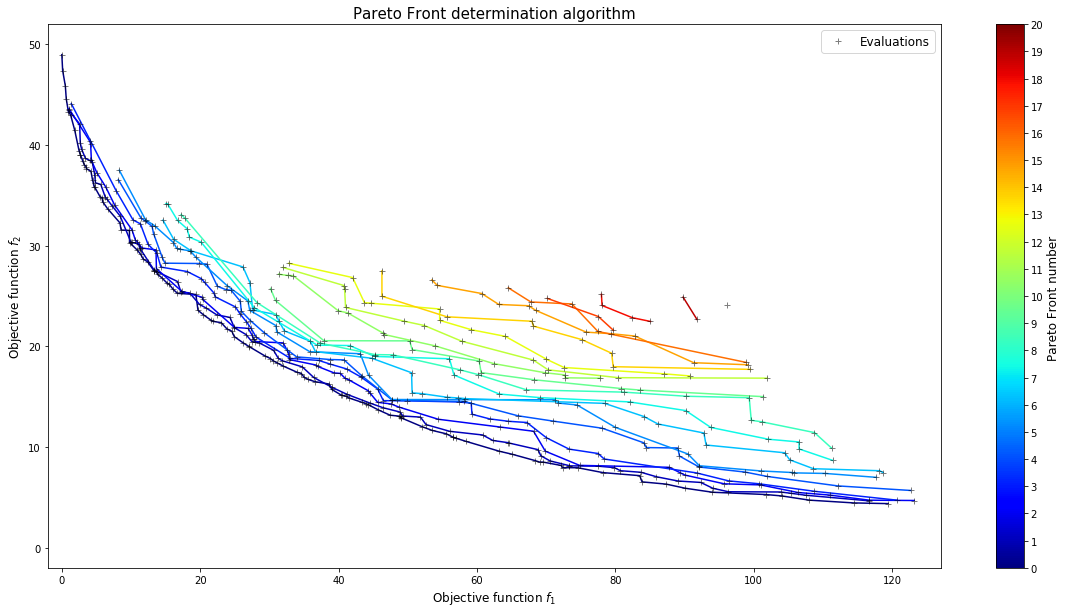

In [492]:
fig, ax0 = plt.subplots(1, figsize=(20,10))
color = cm.jet(np.linspace(0,1,len(PF)))
for i in range(len(PF)):
    ax0.plot(PF[i][np.argsort(PF[i][:,0]),0],PF[i][np.argsort(PF[i][:,0]),1], c = color[i])
ax0.plot(valid_values[:,0],valid_values[:,1],'k+', alpha=0.5, label='Evaluations')
ax0.set_xlabel('Objective function $f_1$', fontsize=12)
ax0.set_ylabel('Objective function $f_2$', fontsize=12)
ax0.set_title('Pareto Front determination algorithm', fontsize=15)
ax0.set_xlim([-2,127])
ax0.set_ylim([-2,52])
ax0.legend(fontsize=12)
sm = plt.cm.ScalarMappable(cmap=cm.jet, norm=plt.Normalize(vmin=0, vmax=len(PF)))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
cbar = plt.colorbar(sm)
cbar.ax.set_yticklabels([np.linspace(0,len(PF),len(PF)+1)])
cbar.set_ticks([np.linspace(0,len(PF),len(PF)+1)])
cbar.set_label('Pareto Front number ', rotation=90, fontsize=12)

Text(0.5,1,'First objective function')

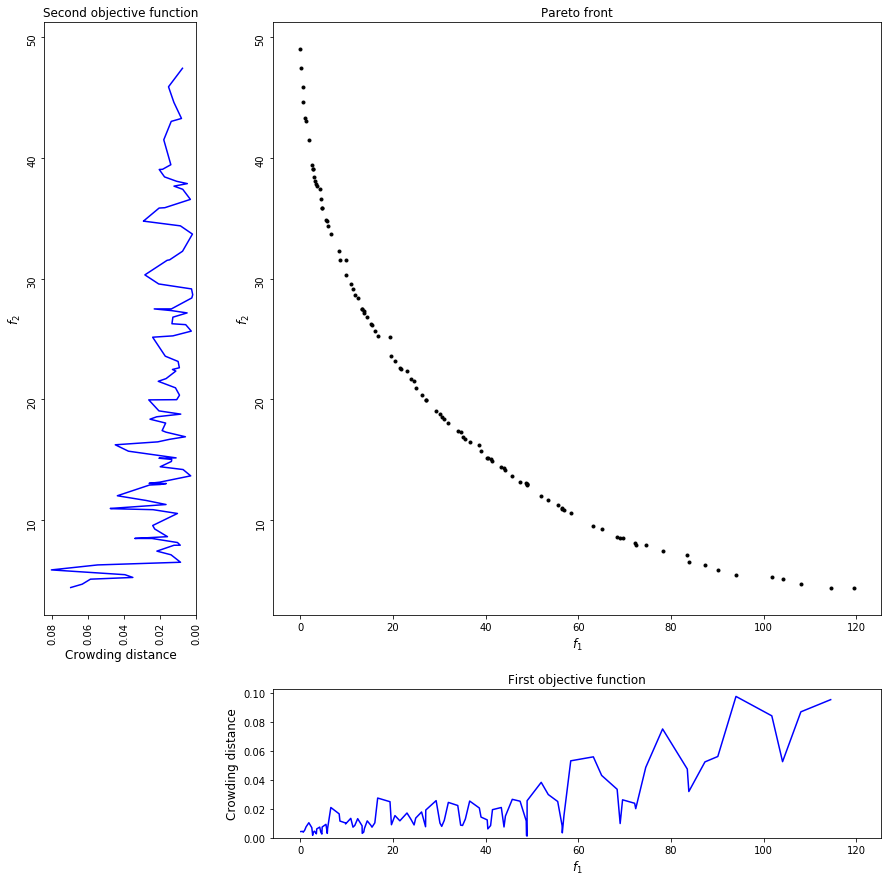

In [443]:
fig = plt.figure(figsize=(15, 15))
grid = plt.GridSpec(2, 2, wspace=0.2, hspace=0.2, width_ratios=[1, 4], height_ratios=[4, 1])
axUL = fig.add_subplot(grid[0]) #upper left
axLR = fig.add_subplot(grid[3]) #lower right
axUR = fig.add_subplot(grid[1]) #upper right

axUR.plot(PF[0][:,0],PF[0][:,1], 'k.')
axUR.tick_params(axis='y', rotation=90)
axUR.set_xlabel('$f_1$',fontsize=12)
axUR.set_ylabel('$f_2$',fontsize=12)
axUR.set_title('Pareto front')

axUL.plot(I[:,1],PF[0][np.argsort(PF[0][:,0]),1],'b')
axUL.set_xlim((0,None))
axUL.set_xlim(axUL.get_xlim()[::-1])
axUL.set_ylim(axUR.get_ylim())
axUL.tick_params(axis='x', rotation=90)
axUL.tick_params(axis='y', rotation=90)
axUL.set_xlabel('Crowding distance', fontsize=12)
axUL.set_ylabel('$f_2$',fontsize=12)
axUL.set_title('Second objective function')

axLR.plot(PF[0][np.argsort(PF[0][:,0]),0],I[:,0],'b')
axLR.set_xlim(axUR.get_xlim())
axLR.set_ylim((0,None))
axLR.set_xlabel('$f_1$',fontsize=12)
axLR.set_ylabel('Crowding distance',fontsize=12)
axLR.set_title('First objective function')

## 1.3 Preselection test

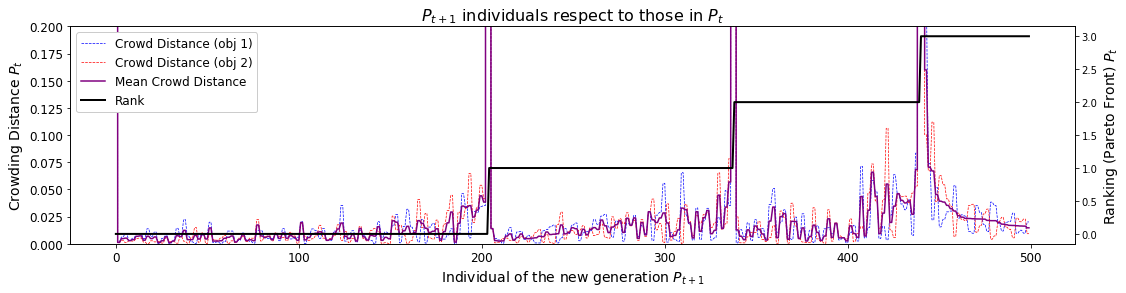

In [493]:
a = preSelection(P[0],P[0],valid_values,valid_values)

np.place(a[:,4],a[:,4]==np.float('inf'),9)
np.place(a[:,3],a[:,3]==np.float('inf'),9)

fig, ax1 = plt.subplots(1, figsize=(18,4))
ax1.plot(a[:,4],'b--',linewidth=0.7,label='Crowd Distance (obj 1)')
ax1.plot(a[:,3],'r--',linewidth=0.7,label='Crowd Distance (obj 2)')
ax1.plot((a[:,3]+a[:,4])/2,color='purple',linewidth=1.5,label='Mean Crowd Distance')
ax1.plot([0.5,0.5],'k',linewidth=2,label='Rank')
ax2 = ax1.twinx()
ax2.plot(a[:,2],'k',linewidth=2,label='Rank')
ax1.set_ylim([0.,0.2]);
ax1.set_xlabel('Individual of the new generation $P_{t+1}$',fontsize=14)
ax1.set_ylabel('Crowding Distance $P_{t}$',fontsize=14)
ax2.set_ylabel('Ranking (Pareto Front) $P_{t}$',fontsize=14)
ax1.set_title('$P_{t+1}$ individuals respect to those in $P_t$',fontsize=16)
ax1.tick_params(axis='both', which='both', labelsize=12)
leg = ax1.legend(loc='upper left', fontsize=12)
leg.get_frame().set_alpha(1)

## 1.4 Binary tournament tests

In [416]:
rank = np.array([0,1,0,1,0,2,0,0,1])
crowd = np.array([[0.7,0.3],[0.3,0.5],[0.1,0.05],[0.4,0.1],[0.5,0.03],[0.15,0.4],[0.23,0.5],[0.33,0.6],[0.4,0.6]])

table = PrettyTable(['Index', 'Rank', 'CrowdD 1', 'CrowdD 2', 'CrowdD Mean'])
for i in range(len(rank)):
    table.add_row([i, rank[i], crowd[i,0], crowd[i,1], np.round(np.mean((crowd[i,0],crowd[i,1])),3)])
print(table)

+-------+------+----------+----------+-------------+
| Index | Rank | CrowdD 1 | CrowdD 2 | CrowdD Mean |
+-------+------+----------+----------+-------------+
|   0   |  0   |   0.7    |   0.3    |     0.5     |
|   1   |  1   |   0.3    |   0.5    |     0.4     |
|   2   |  0   |   0.1    |   0.05   |    0.075    |
|   3   |  1   |   0.4    |   0.1    |     0.25    |
|   4   |  0   |   0.5    |   0.03   |    0.265    |
|   5   |  2   |   0.15   |   0.4    |    0.275    |
|   6   |  0   |   0.23   |   0.5    |    0.365    |
|   7   |  0   |   0.33   |   0.6    |    0.465    |
|   8   |  1   |   0.4    |   0.6    |     0.5     |
+-------+------+----------+----------+-------------+


In [30]:
table = PrettyTable(['Index', 'Rank', 'CrowdD Mean'])
for i in prec_n_operator(rank,crowd):
    table.add_row([i, rank[i], np.round(np.mean((crowd[i,0],crowd[i,1])),3)])
print(table)

+-------+------+-------------+
| Index | Rank | CrowdD Mean |
+-------+------+-------------+
|   0   |  0   |     0.5     |
|   7   |  0   |    0.465    |
|   6   |  0   |    0.365    |
|   4   |  0   |    0.265    |
|   2   |  0   |    0.075    |
|   8   |  1   |     0.5     |
|   1   |  1   |     0.4     |
|   3   |  1   |     0.25    |
|   5   |  2   |    0.275    |
+-------+------+-------------+


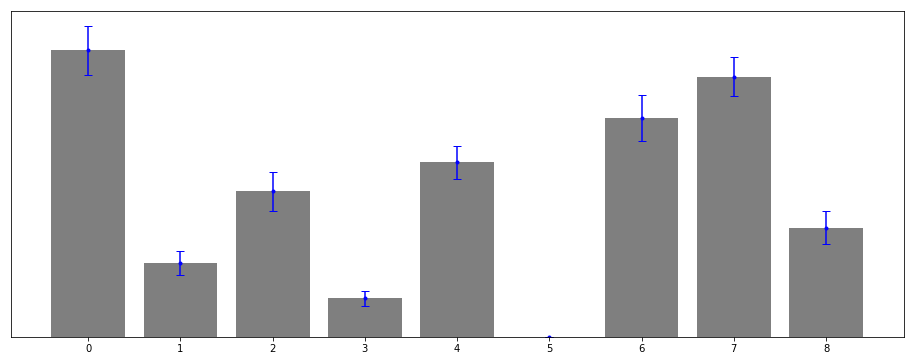

In [33]:
binT = np.zeros((30,500))
stat = np.zeros((binT.shape[0],len(rank)))
mnstd = np.zeros((len(rank),2))

for i in range(binT.shape[0]):
    for j in range(binT.shape[1]):
        binT[i,j] = binaryTournament(rank, crowd)
        
for i in range(binT.shape[0]):
    stat[i,:] = np.histogram(binT[i,:],len(rank))[0]
    
mnstd[:,0] = np.mean(stat, axis=0)
mnstd[:,1] = np.std(stat, axis=0)

fig, ax = plt.subplots(1, figsize=(16,6))
ax.bar(np.linspace(0,len(rank)-1,len(rank)),mnstd[:,0],color='k',alpha=0.5);
ax.errorbar(np.linspace(0,len(rank)-1,len(rank)),mnstd[:,0],mnstd[:,1],fmt='.b',capsize=4)
ax.set_yticks([])
ax.set_xticks(np.linspace(0,len(rank)-1,len(rank)));

## 1.5 Crossover testing

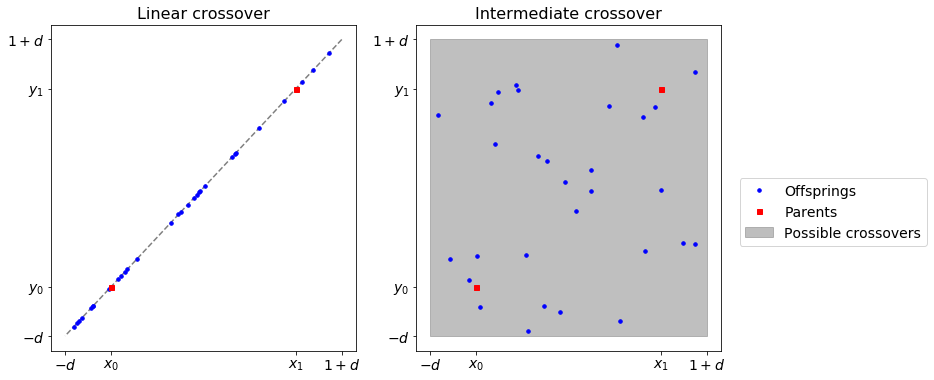

In [34]:
pt1 = np.array([1.,1.])
pt2 = np.array([0.,0.])
d = 0.25

linearC = np.zeros((30,2))
intermC = np.zeros_like(linearC)

for i in range(len(linearC)):
    linearC[i,:] = crossover(pt1, pt2, d, True)
    intermC[i,:] = crossover(pt1, pt2, d, False)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
########## PLOT 1
ax1.plot([(1+d)*np.abs(pt1[0]-pt2[0]),(-d)*np.abs(pt1[0]-pt2[0])], [(1+d)*np.abs(pt1[1]-pt2[1]),(-d)*np.abs(pt1[1]-pt2[1])] ,'--k', alpha=0.5)
ax1.plot(linearC[:,0], linearC[:,1], '.b', markersize=7)
ax1.plot([pt1[0],pt2[0]], [pt1[1],pt2[1]], 'sr', markersize = 5, label ='Parents')
ax1.set_title('Linear crossover', fontsize=16)

ax1.set_xticks([(-d)*np.abs(pt1[0]-pt2[0]),pt2[0],pt1[0],(1+d)*np.abs(pt1[0]-pt2[0])])
labels = [item.get_text() for item in ax1.get_xticklabels()]
labels[0] = r'$-d$'
labels[1] = r'$x_0$'
labels[2] = r'$x_1$'
labels[3] = r'$1+d$'
ax1.set_xticklabels(labels, fontsize=14)

ax1.set_yticks([(-d)*np.abs(pt1[1]-pt2[1]),pt2[1],pt1[1],(1+d)*np.abs(pt1[1]-pt2[1])])
labels = [item.get_text() for item in ax1.get_yticklabels()]
labels[0] = r'$-d$'
labels[1] = r'$y_0$'
labels[2] = r'$y_1$'
labels[3] = r'$1+d$'
ax1.set_yticklabels(labels, fontsize=14)

########## PLOT 2
ax2.fill_between([-d,1+d],[1+d,1+d],[-d,-d],color='grey',alpha=0.5, label='Possible crossovers')
ax2.plot(intermC[:,0], intermC[:,1], '.b', markersize=7, label='Offsprings')
ax2.plot([pt1[0],pt2[0]], [pt1[1],pt2[1]], 'sr', markersize = 5, label ='Parents')
ax2.set_title('Intermediate crossover', fontsize=16)

ax2.set_xticks([(-d)*np.abs(pt1[0]-pt2[0]),pt2[0],pt1[0],(1+d)*np.abs(pt1[0]-pt2[0])])
labels = [item.get_text() for item in ax2.get_xticklabels()]
labels[0] = r'$-d$'
labels[1] = r'$x_0$'
labels[2] = r'$x_1$'
labels[3] = r'$1+d$'
ax2.set_xticklabels(labels, fontsize=14)

ax2.set_yticks([(-d)*np.abs(pt1[1]-pt2[1]),pt2[1],pt1[1],(1+d)*np.abs(pt1[1]-pt2[1])])
labels = [item.get_text() for item in ax2.get_yticklabels()]
labels[0] = r'$-d$'
labels[1] = r'$y_0$'
labels[2] = r'$y_1$'
labels[3] = r'$1+d$'
ax2.set_yticklabels(labels, fontsize=14)

ax2.legend(bbox_to_anchor=(1.7,0.55),fontsize=14)

## 1.6 Mutation testing and parameter sweep

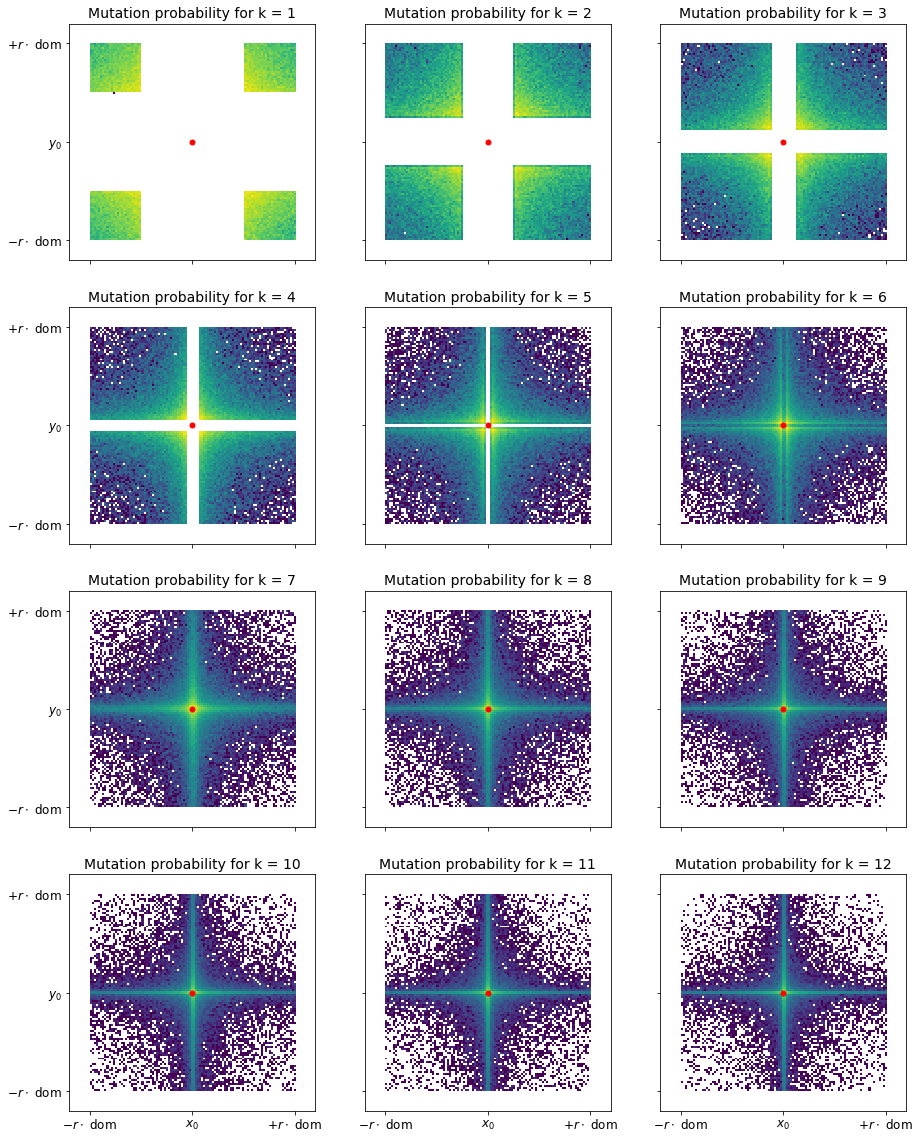

In [37]:
kPS = np.zeros((100000,2))

K = [1,2,3,4,5,6,7,8,9,10,11,12]
kVal = 0
    
fig, ax = plt.subplots(4, 3, figsize=(15,20), sharex='col', sharey='row')
for i in range(4):
    for j in range(3):
        for k in range(len(kPS)):
            kPS[k,:] = mutation(np.array([0.,0.]), 0.1, np.array([1.,1.]), K[kVal], False)
        ax[i][j].hist2d(kPS[:,0], kPS[:,1], bins=100, norm=LogNorm())
        ax[i][j].plot([0.], [0.], 'or', markersize = 5)
        ax[i][j].set_xlim([-0.12,0.12])
        ax[i][j].set_ylim([-0.12,0.12])
        ax[i][j].set_title('Mutation probability for k = %i' %K[kVal], fontsize=14)
        
        ax[i][j].set_xticks([-0.1,0,0.1])
        if i == 3:
            labels = [item.get_text() for item in ax[i][j].get_xticklabels()]
            labels[0] = r'$-r\cdot$ dom'
            labels[1] = r'$x_0$'
            labels[2] = r'$+r\cdot$ dom'
            ax[i][j].set_xticklabels(labels, fontsize=12)

        ax[i][j].set_yticks([-0.1,0,0.1])
        if j == 0:
            labels = [item.get_text() for item in ax[i][j].get_yticklabels()]
            labels[0] = r'$-r\cdot$ dom'
            labels[1] = r'$y_0$'
            labels[2] = r'$+r\cdot$ dom'
            ax[i][j].set_yticklabels(labels, fontsize=12)
        
        kVal += 1

[Text(0,0,'$-r\\cdot$ dom'), Text(0,0,'$y_0$'), Text(0,0,'$+r\\cdot$ dom')]

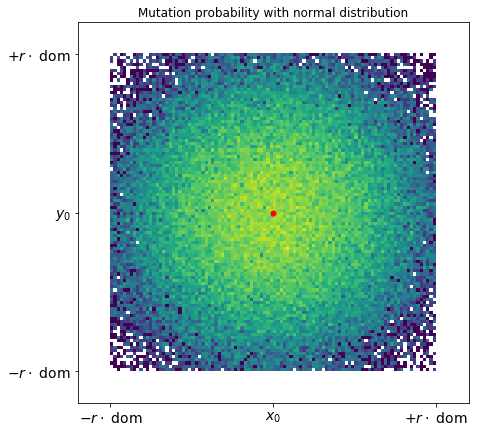

In [236]:
norm = np.zeros((100000,2))

for k in range(len(norm)):
    norm[k,:] = mutation(np.array([0.,0.]), 0.1, np.array([1.,1.]), np.nan, True)

fig, ax = plt.subplots(1, figsize=(7,7))
ax.hist2d(norm[:,0], norm[:,1], bins=100, norm=LogNorm())
ax.plot([0.], [0.], 'or', markersize = 5)
ax.set_xlim([-0.12,0.12])
ax.set_ylim([-0.12,0.12])
ax.set_title('Mutation probability with normal distribution')

ax.set_xticks([-0.1,0,0.1])
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = r'$-r\cdot$ dom'
labels[1] = r'$x_0$'
labels[2] = r'$+r\cdot$ dom'
ax.set_xticklabels(labels, fontsize=14)

ax.set_yticks([-0.1,0,0.1])
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[0] = r'$-r\cdot$ dom'
labels[1] = r'$y_0$'
labels[2] = r'$+r\cdot$ dom'
ax.set_yticklabels(labels, fontsize=14)

## 2. Main loop of the NSGA-II algorithm

In [63]:
def constrainedPts(points, const, constVal, compMode):
    #Let's create a function that checks if any of the points is constrained and returns its boolean
    boolMat = np.zeros([len(constVal), points.shape[0]])
    #Let's get the points that are valid under the constraints
    for i in range(len(constVal)):
        if compMode[i] == 'leq':
            boolMat[i,:] = np.logical_or(const(points[:,0], points[:,1], i) < constVal[i], const(points[:,0], points[:,1], i) == constVal[i])
        elif compMode[i] == 'less':
            boolMat[i,:] = const(points[:,0], points[:,1], i) < constVal[i]
        elif compMode[i] == 'geq':
            boolMat[i,:] = np.logical_or(const(points[:,0], points[:,1], i) > constVal[i], const(points[:,0], points[:,1], i) == constVal[i])
        elif compMode[i] == 'greater':
            boolMat[i,:] = const(points[:,0], points[:,1], i) > constVal[i]
        elif compMode[i] == 'eq':
            boolMat[i,:] = const(points[:,0], points[:,1], i) == constVal[i]
        else:
            raise RuntimeError('Bad comparison mode matrix')
    #Once all the comparisons are made, the output should be an OR array along the boolMat
    return np.logical_or.reduce(np.logical_not(boolMat))

In [359]:
# Function attribute to count callings (future CFD simulations)
fun.counter = 0
# Number of individuals per generation
N = 500
# Generation list (new generations will be appended at the end)
P = []
# Function evaluation (new evaluations will be appended at the end)
funEval = []
# Current generation
p = 0
# Let's create the first generation with random individuals
# Transpose is used to have the number of individuals in rows and coordinates in columns
P.append(np.array([x_low+np.random.rand(N)*(x_high-x_low),y_low+np.random.rand(N)*(y_high-y_low)]).T)
# Constrained values will be replaced, given new random numbers in its places
while sum(constrainedPts(P[p], const, constVal, compMode)) != 0:
    # The points where the constraints are not fulfilled ...
    boolMat = constrainedPts(P[p], const, constVal, compMode)
    # ... are replaced with random numbers
    for i in np.argwhere(boolMat == True):
        P[p][i] = np.array([x_low+np.random.rand(1)*(x_high-x_low),y_low+np.random.rand(1)*(y_high-y_low)]).T
# Preallocation of space for the temporary function evaluation
fE = np.zeros((N,funNo))
# Evaluation of the functions 
for i in range(funNo):
    fE[:,i] = fun(P[p][:,0], P[p][:,1], i)
# Append the temporary function evaluation to the list
funEval.append(fE)
# Fitness evaluation of the population according to Pareto front rules
_, F = fastNonDominatedSort(funEval[p])